## DS7731 - Mini Lab (SVM Part)
Team: Amber, Jeremy, Lance, Shawn 

In [1]:
# load required libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()
%matplotlib inline 

from sklearn.svm import SVC #load the SVM-related library
# load model selection/metric related library 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 

# we will try Pipelining if we have more time 
from sklearn.pipeline import Pipeline 



In [2]:
# import the telco churn data as dataframe named 'df'
url = 'https://raw.githubusercontent.com/jotsap/DS7331/master/data/churn.csv'
df = pd.read_csv(url)

In [3]:
# Let's check if it is loaded ok 
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# create another placeholder dataframe df_impute for imputed features, and a series df_y to hold response variable 
df_impute = pd.DataFrame()
df_y = df['Churn'].map(dict(Yes=1, No=0))

In [5]:
# Date Impute - Numerical data 
df_impute['Tenure'] = df['tenure']
df_impute['MonthlyCharges'] = df['MonthlyCharges']
# As discussed in the ETA stage, fill missing values of TotalCharges as zero 
df['TotalCharges'] = df['TotalCharges'].replace(' ',0)
df_impute['TotalCharges'] = df['TotalCharges'].astype(float)

In [6]:
# converting binary categorical variables 
df_impute['FemaleYN'] = df['gender'].map(dict(Male=0, Female=1))
df_impute['Partner'] = df['Partner'].map(dict(Yes=1, No=0))
df_impute['Dependents'] = df['Dependents'].map(dict(Yes=1, No=0))
df_impute['PhoneService'] = df['PhoneService'].map(dict(Yes=1, No=0))
df_impute['SeniorCitizen'] = df['SeniorCitizen']

In [7]:
# encoding variables with multiple categories  
multi_category = ['MultipleLines', 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies','Contract','PaperlessBilling','PaymentMethod']
multi_prefix = ['MLines', 'IService', 'OSecurity', 'OBackup', 'DProtection', 'TSupport','STV', 'SMovies','Contract','PBilling','PMethod']

for seq, category in enumerate(multi_category):
    # get the category from multi_category, and use the prefix from multi_prefix list 
    tmp_df = pd.get_dummies(df[category], multi_prefix[seq])
    # append to the df_impute dataframe
    df_impute = pd.concat((df_impute,tmp_df), axis=1)


In [8]:
df_impute.head()

,Tenure,MonthlyCharges,TotalCharges,FemaleYN,Partner,Dependents,PhoneService,SeniorCitizen,MLines_No,MLines_No phone service,...,SMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PBilling_No,PBilling_Yes,PMethod_Bank transfer (automatic),PMethod_Credit card (automatic),PMethod_Electronic check,PMethod_Mailed check
0,1,29.85,29.85,1,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,0,0,0,0,0,1,...,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [9]:
# Let's check the distribution of response variable. As we can see below, the counting of 'Yes' and 'No' is imbalanced. So we might as well stratifying samples when splitting test/train datasets. 
df.groupby(by='Churn').size()


Churn
No     5174
Yes    1869
dtype: int64

In [10]:
# cross validation shuffling with stratification to mitigate imbalance of Yes/No. 
from sklearn.model_selection import StratifiedShuffleSplit

y = df_y.values # transform df_y into numpy matrix 
X = df_impute.values # the same with X 

# we will iterate thee CV, and train/test split ratio will be 8:2 
num_cv_iterations = 10
num_instances = len(y)
cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations, test_size=0.2)

print(cv_object)


StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None)


In [11]:
# split train/test datasets based on CV split, and scale the data 
for train_indices, test_indices in cv_object.split(X,y):
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]


In [12]:
# Let's scale the data. We will scale based on train data only to avoid snooping (keep test dataset intact from contamination)
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics as mt 

scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

In [13]:
# Now we will play with SVM. As Professor advised, we will use kinda automated hyper parameter list generation to make C values candidate. And we compare accuracy among different SVM kernel methods 


c_values = np.logspace(-3.0, 2.0, num=10)
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values) 
model = SVC(gamma='auto') 
scoring = 'accuracy'
kfold = KFold(n_splits=num_cv_iterations)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv_object, iid=True)
grid_result = grid.fit(X_train_scaled, y_train)



In [14]:
# The suggested linear kernel method and hyper parameter will be used to make final predictors for validation 
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.802484 using {'C': 0.046415888336127795, 'kernel': 'sigmoid'}


In [21]:
# final model fitting 
svm_model = SVC(C=0.046415888336127795, kernel='sigmoid', gamma='auto')
svm_model.fit(X_train_scaled, y_train)

# estimate metrics 
y_hat = svm_model.predict(X_test_scaled) 
print(accuracy_score(y_test, y_hat))
print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

0.8026969481902059
[[930 105]
 [173 201]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [19]:
# To all. The cell below only runs when the linear kernel is selected 
# The model below are from one of best resutls when running 'linear' SVM kernel. 

svm_ln = SVC(C=26, kernel='linear', gamma='auto')
svm_ln.fit(X_train_scaled, y_train)

y_hat = svm_ln.predict(X_test_scaled) 
print(accuracy_score(y_test, y_hat))

print(svm_ln.support_vectors_.shape)
print(svm_ln.support_.shape)
print(svm_ln.n_support_)


0.8026969481902059
(2587, 41)
(2587,)
[1295 1292]


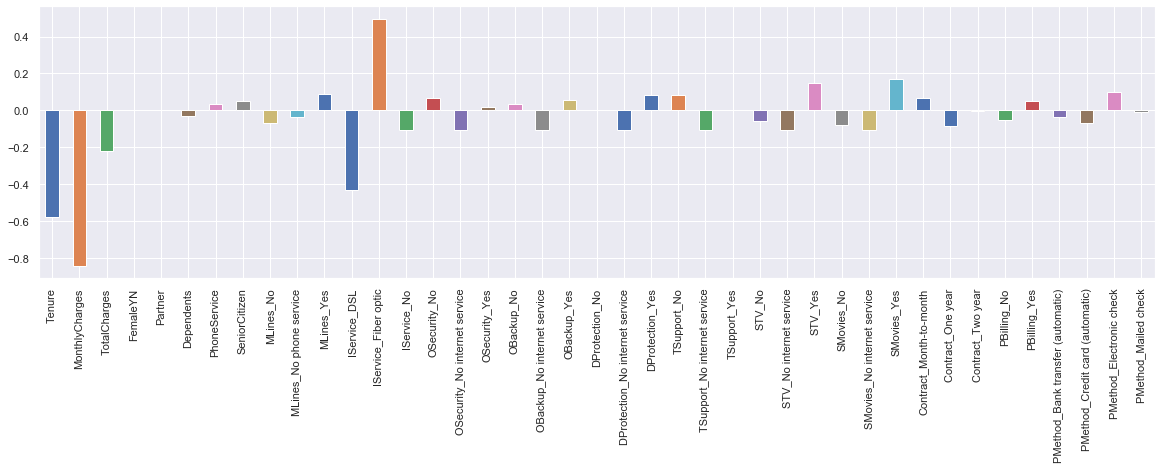

In [20]:
# How do we understand the weights from SVM training 
plt.figure(figsize=(20,5))
weights = pd.Series(svm_ln.coef_[0], index=df_impute.columns)
weights.plot(kind='bar')
